## MSAE training and feature analysis

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [ ]:
"""Import packages."""

import math
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from IPython.display import HTML
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from nldisco import train as nt
from nldisco.util import vec_r2

In [2]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

In [3]:
"""Spec some dataset info."""

session_id = 732592105
out_dir = Path(r"/nfs/nhome/live/jbhagat/mini/data/allen_data/sessions_proc")
print(f"{out_dir.exists()=}")

# gonna want a gpu if training! not necessary if loading saved features from a trained model
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

out_dir.exists()=True
device=device(type='cuda')


In [11]:
"""Load spikes and set sae config."""

spk_cts_file = out_dir / f"{session_id}" / "spike_counts.csv"
spk_cts_df = pd.read_csv(Path(spk_cts_file), index_col=0)
spk_cts = t.from_numpy(spk_cts_df.to_numpy()).bfloat16().to(device)
spk_cts /= spk_cts.max()  # max normalize spike counts

# dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = {128: 12, 224: 24, 320: 36}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
# dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = {128: 1, 224: 1.25, 320: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
n_inst = 2

display(spk_cts_df)

,915957946,915958108,915958104,915958534,915958067,915958058,915958122,915958824,915958211,915958207,915958424,915958015,...,915966459,915966399,915966397,915966384,915966556,915966611,915966322,915966645,915966529,915966526,915966523,915966387
915957951,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.043457,0.043457,0.043457,0.043457,0.0,0.043457,...,0.000000,0.0,0.043457,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.043457,0.086914
0.000000,0.043457,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.043457,0.000000,0.043457,0.0,0.086914,...,0.043457,0.0,0.000000,0.0,0.0,0.043457,0.0,0.0,0.043457,0.000000,0.000000,0.130859
0.043457,0.086914,0.000000,0.217773,0.0,0.217773,0.0,0.000000,0.000000,0.043457,0.043457,0.0,0.130859,...,0.000000,0.0,0.043457,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.043457,0.043457


## Train MSAE

In [ ]:
sed_cfg = nt.SedConfig(
    n_input=spk_cts.shape[1],
    dsed_topk_map=dsae_topk_map,
    dsed_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sed = nt.Sed(sed_cfg).to(device)
loss_fn = nt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = nt.optimize(  # train model
    spk_cts=spk_cts,
    sed=sed,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sed.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step:   1%|          | 22/3560 [00:00<00:16, 210.61it/s, loss=0.00620,  l0_mean=36.0, l0_std=21.902769088745117, frac_dead=0.0]

SAE batch training step: 100%|██████████| 3560/3560 [00:36<00:00, 96.87it/s, loss=0.00110,  l0_mean=36.0, l0_std=8.881844520568848, frac_dead=0.26875001192092896] 


## Validate SAEs

In [ ]:
"""Check for nans in weights."""

sed.W_dec.isnan().sum(), sed.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

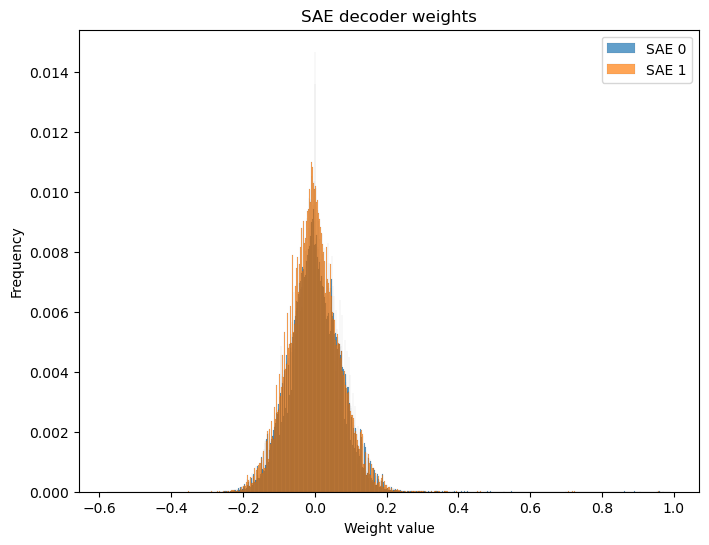

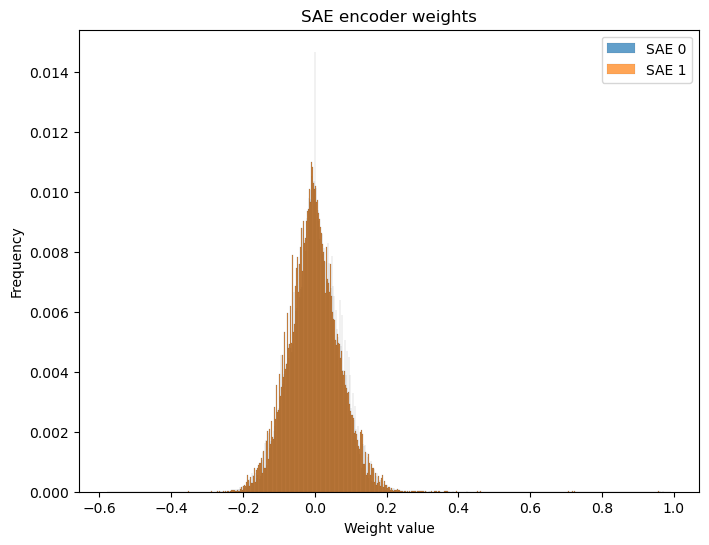

In [ ]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sed.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SED {inst}")
    
ax.set_title("SED decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_enc_flat = asnumpy(sed.W_enc[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SED {inst}")
    
ax.set_title("SED encoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step:  31%|███       | 55/178 [00:00<00:00, 548.92it/s]

SAE batch evaluation step: 100%|██████████| 178/178 [00:00<00:00, 556.09it/s]
/nfs/nhome/live/jbhagat/mini/src/mini/train.py:478: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_density.legend()


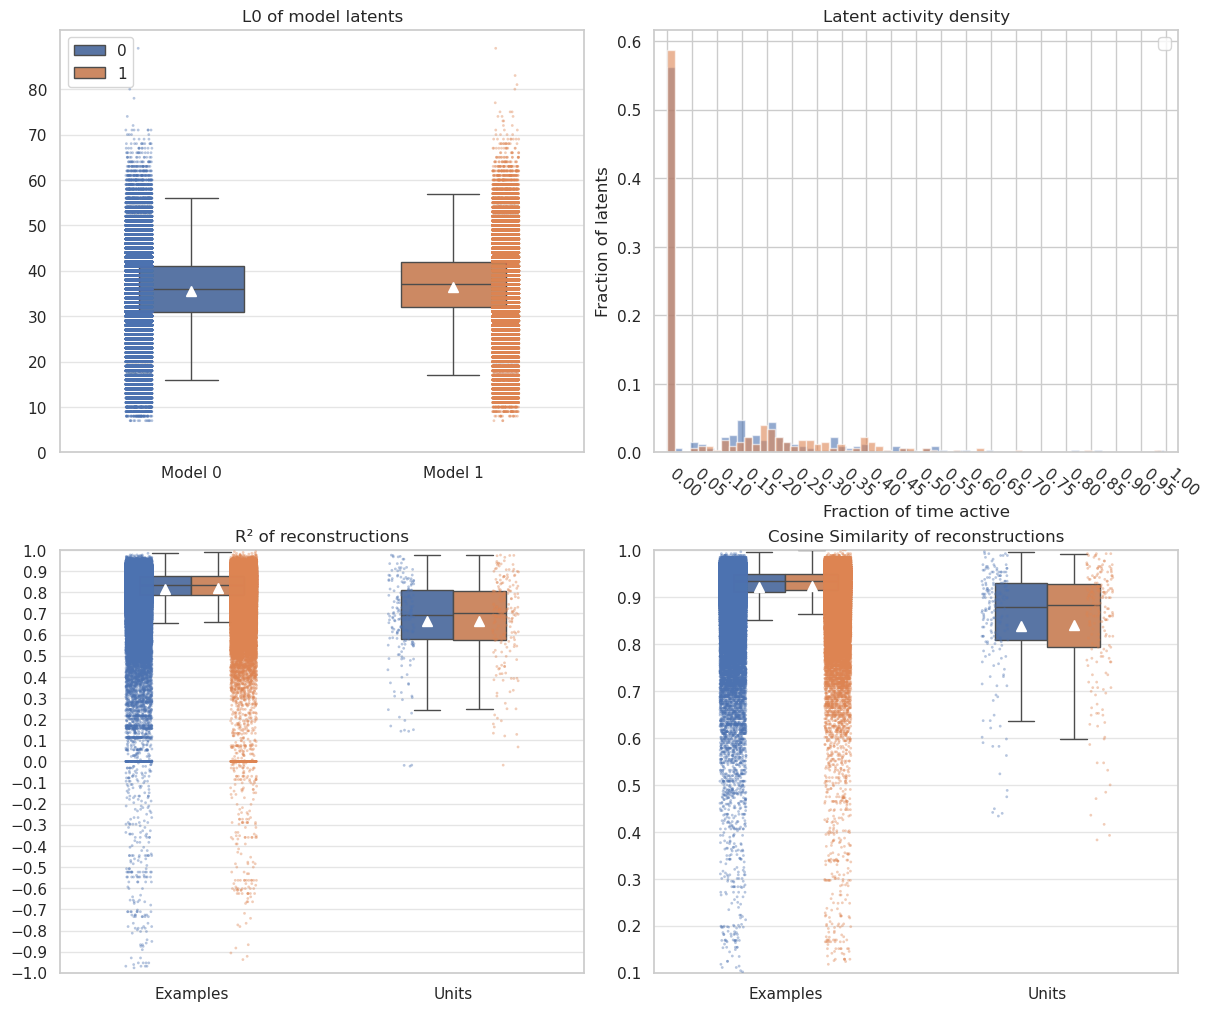

In [ ]:
"""Visualize metrics over all examples and units."""

fig, topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = nt.eval_model(spk_cts, sed, batch_sz=batch_sz)

In [22]:
from matplotlib.collections import PathCollection

In [51]:
axes = fig.get_axes()

# axes[0].set_ylim(0, 100)
# axes[0].legend(["Model 0", "", "Model 1"], loc="upper right", fontsize=14)
# Set xlabel
# axes[0].set_xticklabels(["Model 0", "Model 1"])
# axes[0].set_title("L0 of model latents")
# axes[1].set_title("R² of reconstructions")
# axes[2].set_title("Cosine similarity of reconstructions")
# axes[1].set_xticklabels(["Examples", "Units"], fontsize=14)
# axes[2].set_xticklabels(["Examples", "Units"], fontsize=14)

# Set 10 ticks from -1 to 1
# axes[1].set_yticks(np.linspace(-1, 1, 11))

for i, ax in enumerate(axes):
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
        ticklabel.set_fontsize(12.5)
    
    # Rasterize scatter (PathCollection) types
    for artist in ax.get_children():
        if isinstance(artist, PathCollection):
            artist.set_rasterized(True)

for bar in axes[1].patches:
    current_height = bar.get_height()

    if current_height > 0.5:
        # Subtract 0.36 from the height
        new_height = current_height - 0.38
        bar.set_height(new_height)
        # Optionally change color to see which bars were modified
        # bar.set_facecolor("red")
    else:
        # Multiply the height by 2
        new_height = current_height * 1.9
        bar.set_height(new_height)
        # bar.set_facecolor("green")

axes[1].relim()
axes[1].autoscale_view()

In [64]:
for ticklabel in axes[1].get_xticklabels():
    ticklabel.set_fontsize(10.5)


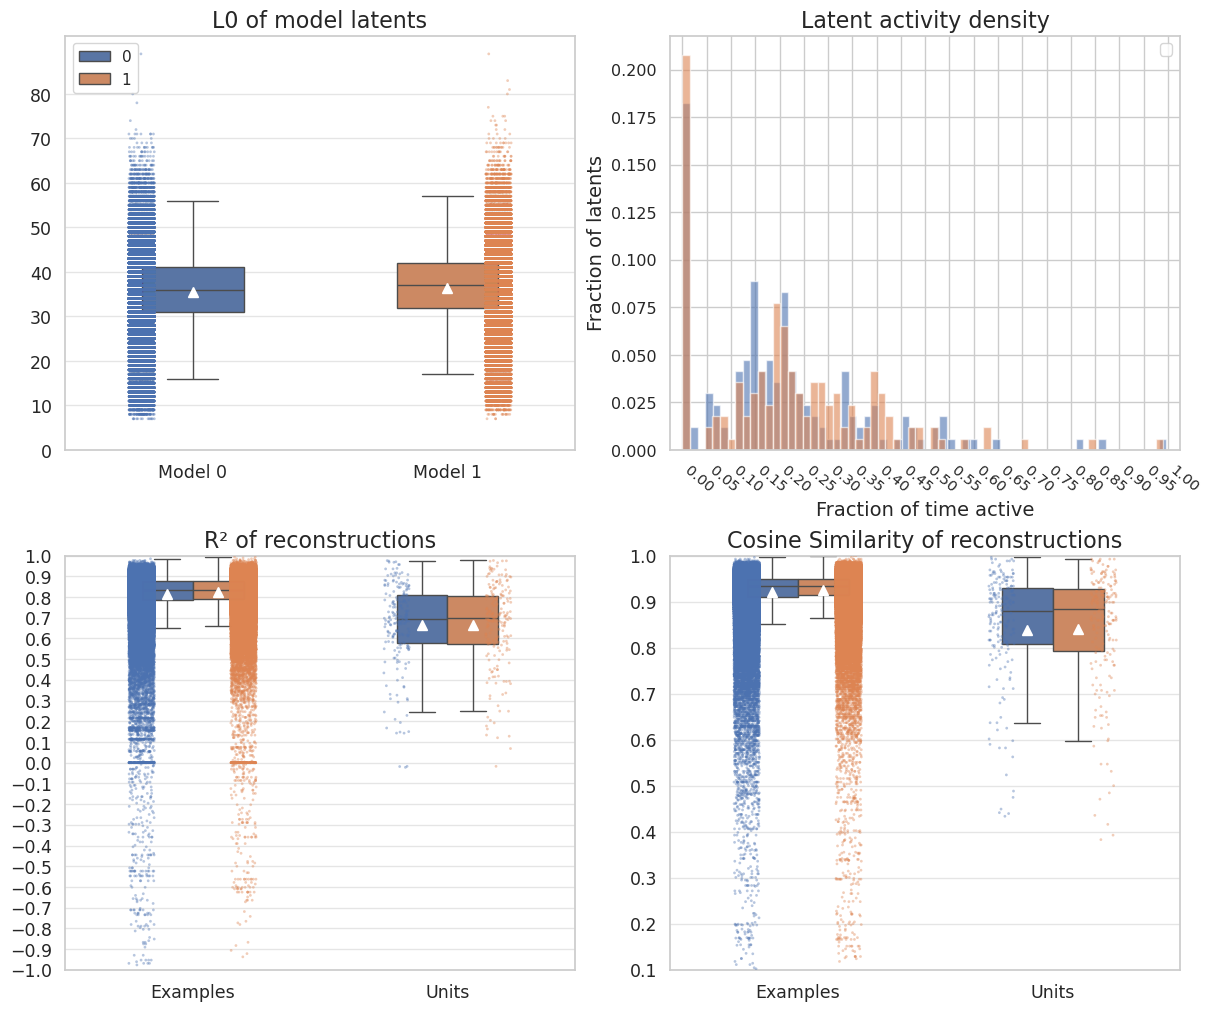

In [65]:
fig

In [66]:
# --- Save figure as SVG or PDF ---
fig.savefig("my_figure.svg", format="svg", bbox_inches="tight", dpi=600)


In [ ]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SED instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.970
SAE instance 1 R² (summed spike count over all units per example) = 0.974


### Remove bad units and retrain.

In [ ]:
"""Re-train."""

r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spk_cts[:, keep_mask]

sed_cfg = nt.SedConfig(
    n_input=spk_cts.shape[1],
    dsed_topk_map=dsae_topk_map,
    dsed_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sed = nt.Sed(sed_cfg).to(device)
loss_fn = nt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = nt.optimize(  # train model
    spk_cts=spk_cts,
    sed=sed,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sed.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

frac units above r2_thresh=0.1: 0.88
Number to keep: 141 / 160


SAE batch training step: 100%|██████████| 3560/3560 [00:38<00:00, 91.51it/s, loss=0.00107,  l0_mean=24.0, l0_std=6.168454170227051, frac_dead=0.84716796875] 


SAE batch evaluation step: 100%|██████████| 178/178 [00:00<00:00, 529.00it/s]


SAE instance 0 R² (summed spike count over all units per example) = 0.972
SAE instance 1 R² (summed spike count over all units per example) = 0.973


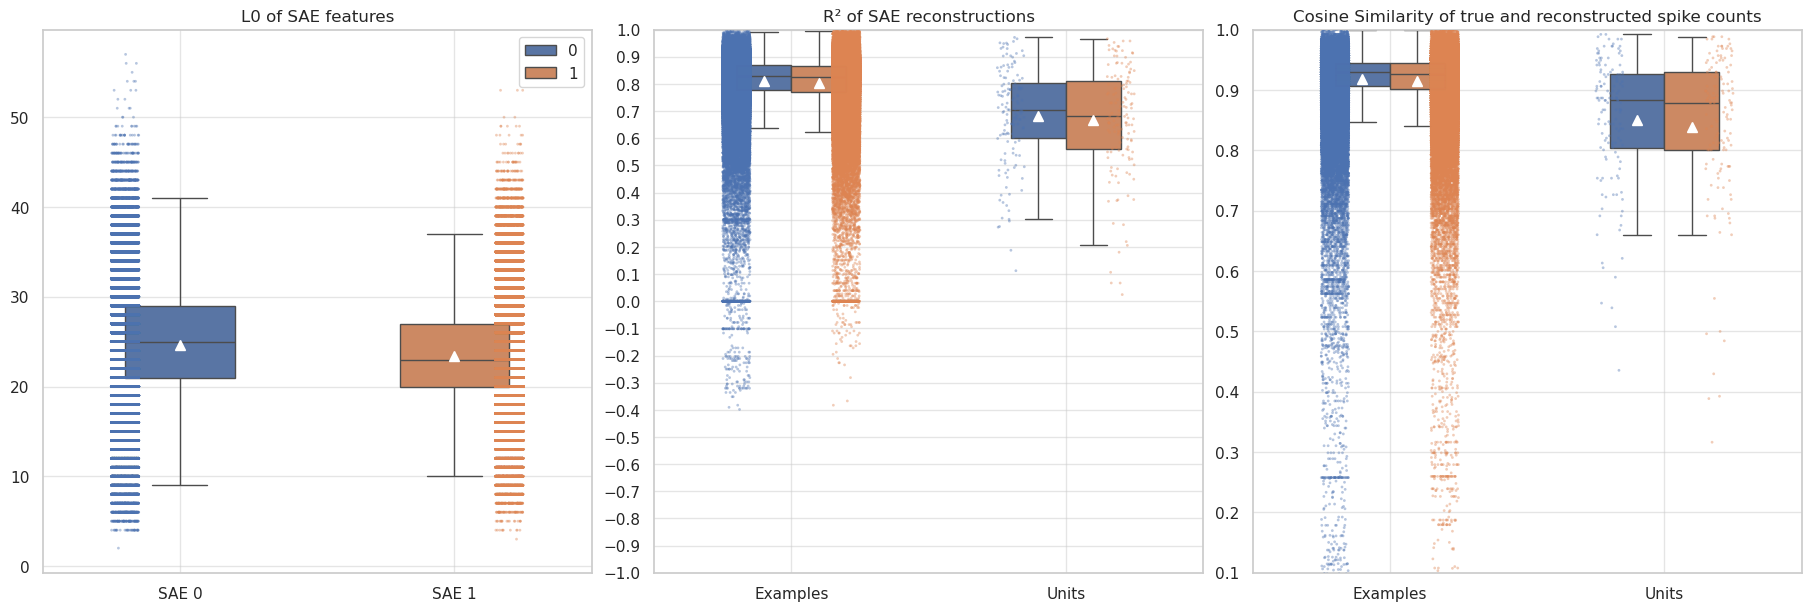

In [ ]:
"""Re-visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = nt.eval_model(spk_cts, sed, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SED instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

In [15]:
"""Save spike counts."""

save_spk_cts = True

if save_spk_cts:
    # Save the spike counts to a CSV file
    save_path = out_dir / f"{session_id}" / "spike_counts.csv"
    spk_cts_df_new = pd.DataFrame(asnumpy(spk_cts.float()))
    spk_cts_df_new.columns = spk_cts_df.columns[keep_mask]
    spk_cts_df = spk_cts_df_new
    display(spk_cts_df)
    spk_cts_df.to_csv(save_path, index=False)
    print(f"Spike counts saved to {save_path}")

,950939245,950937672,950937686,950937344,950937434,950938133,950937989,950939297,950937469,950937620,...,950965894,950965885,950965875,950965801,950965785,950965980,950965214,950966712,950965410,950965866
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183041,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.095215,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.095215,0.0,0.0,0.047607
183042,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.047607,0.047607,...,0.047607,0.0,0.0,0.047607,0.000000,0.0,0.000000,0.0,0.0,0.095215
183043,0.0,0.047607,0.047607,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047607,...,0.000000,0.0,0.0,0.047607,0.047607,0.0,0.000000,0.0,0.0,0.000000
183044,0.0,0.000000,0.000000,0.047607,0.0,0.0,0.0,0.0,0.000000,0.047607,...,0.000000,0.0,0.0,0.047607,0.047607,0.0,0.000000,0.0,0.0,0.047607


Spike counts saved to /nfs/nhome/live/jbhagat/mini/data/allen_data/sessions_proc/742951821/spike_counts.csv


## Get environment / behavior (meta)data

In [16]:
"""Set vars for saving / loading environment / behavior (meta)data!"""

load_metadata = False
save_metadata = True
metadatafile = out_dir / f"{session_id}" / "metadata.csv"
bin_s = 0.05  # 50 ms sampling


In [17]:
"""Load metadata."""

if load_metadata:
    metadata = pd.read_csv(metadatafile)

In [18]:
"""Acquire metadata from Allen SDK."""

if not load_metadata:
    manifest_path = out_dir.parent / "manifest.json"
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    session_data = cache.get_session_data(session_id)
    metadata = session_data.get_stimulus_table()

    print("Invalid times:")
    display(session_data.get_invalid_times())

    # Add running, gaze, and pupil data to metadata if found.

    running_df = session_data.running_speed
    gaze_df = session_data.get_screen_gaze_data()
    pupil_df = session_data.get_pupil_data()

    print("Running speed:")
    display(running_df)
    print("Gaze data:")
    display(gaze_df)
    print("Pupil data:")
    display(pupil_df)

    # Reformat metadata
    metadata["start_time"] = round(metadata["start_time"] / bin_s) * bin_s
    metadata["stop_time"] = round(metadata["stop_time"] / bin_s) * bin_s

    init_vis_time = metadata.iloc[0]["start_time"]
    new_init_vis_idx = int(init_vis_time / bin_s) + 1

    time_range = np.arange(0, metadata.iloc[-1]["stop_time"] + bin_s, bin_s)
    time_df = pd.DataFrame({"time": pd.Series(time_range).round(2)})

    # Create a new dataframe with just the time points
    time_df["start_time"] = time_df["time"]
    time_df["stop_time"] = time_df["time"] + 0.05
    time_df["duration"] = 0.05

    # Merge the time_df with metadata
    metadata = pd.merge_asof(
        time_df.sort_values("time"),
        metadata.sort_values("start_time"),
        left_on="time",
        right_on="start_time",
        direction="backward"
    )

    # Merge additional behavioral data
    if running_df is not None:
        running_df["start_time"] = round(running_df["start_time"] / bin_s) * bin_s
        running_df["end_time"] = round(running_df["end_time"] / bin_s) * bin_s
        running_df = running_df.rename(columns={"start_time": "time"})

        metadata = pd.merge_asof(
            metadata.reset_index(drop=True),  # Reset index to get "time" as a column
            running_df[["time", "velocity"]].sort_values("time"),
            on="time",
            direction="backward"
        )
    
    if gaze_df is not None:
        # raw_pupil_area, raw_screen_coordinates_x_cm, raw_screen_coordinates_y_cm
        gaze_df.dropna(inplace=True)
        gaze_df = gaze_df.reset_index().rename(columns={"Time (s)": "time"})
        gaze_df["time"] = round(gaze_df["time"] / bin_s) * bin_s
        keep_cols = [
            "time", 
            "raw_pupil_area", 
            "raw_screen_coordinates_x_cm", 
            "raw_screen_coordinates_y_cm"
        ]
        drop_cols = gaze_df.columns.difference(keep_cols).tolist()
        gaze_df = gaze_df.drop(columns=drop_cols)
        
        metadata = pd.merge_asof(
            metadata.reset_index(drop=True),  # Reset index to get "time" as a column
            gaze_df.sort_values("time"),
            on="time",
            direction="backward"
        )
    
    if pupil_df is not None:
        print("ADD PUPIL DATA")
        # eye_center_x, eye_center_y, pupil_center_x, pupil_center_y

    # Clean up
    metadata = (metadata.
        set_index("time")
        .drop(columns=["start_time_x", "stop_time_x", "duration_x"])
        .rename(columns={"start_time_y": "start_time", "stop_time_y": "stop_time", "duration_y": "duration"})
    )

    metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_condition_id"] = -1
    metadata["stimulus_condition_id"] = metadata["stimulus_condition_id"].astype(int)
    metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_name"] = ""

    metadata.loc[metadata.index[0:new_init_vis_idx], "start_time"] = 0
    metadata.loc[metadata.index[0:new_init_vis_idx], "stop_time"] = init_vis_time
    metadata["duration"] = metadata["stop_time"] - metadata["start_time"]

    first_cols = [
        "stimulus_condition_id",
        "stimulus_name",
        "stimulus_block",
        "start_time",
        "stop_time",
        "duration",
        "orientation",
        "temporal_frequency",
        "spatial_frequency",
        "contrast",
        "x_position",
        "y_position"
    ]
    other_cols = metadata.columns.difference(first_cols).tolist()
    metadata = metadata.reindex(columns=(first_cols + other_cols))
    metadata = metadata.iloc[0:n_recon_examples].reset_index(drop=True)

    # Running window average of velocity
    window = int(0.25 / bin_s)  # 250 ms window
    metadata["velocity"] = metadata["velocity"].rolling(window=window, min_periods=1).mean()

/nfs/nhome/live/jbhagat/mambaforge/envs/mini/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nfs/nhome/live/jbhagat/mambaforge/envs/mini/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Invalid times:


,start_time,stop_time,tags
id,,,
0,996.94,1129.13,"[EcephysProbe, 769322716, probeC]"
1,3167.80,3226.30,"[EcephysProbe, 769322716, probeC]"
2,4122.34,4185.04,"[EcephysProbe, 769322716, probeC]"
3,5867.62,6115.02,"[EcephysProbe, 769322716, probeC]"
4,7262.80,7426.43,"[EcephysProbe, 769322716, probeC]"
5,8429.42,8493.92,"[EcephysProbe, 769322716, probeC]"
6,981.03,1127.81,"[EcephysProbe, 769322714, probeB]"


Running speed:


,start_time,end_time,velocity
0,24.63459,24.65021,-0.636992
1,24.66653,24.68321,0.645780
2,24.68321,24.70007,-2.358218
3,24.71668,24.73321,0.806473
4,24.73321,24.75028,-0.421951
...,...,...,...
366296,9212.19111,9212.20875,1.411839
366297,9212.22796,9212.24148,-2.867140
366298,9212.24148,9212.25758,0.238695
366299,9212.27409,9212.29080,1.901974


Gaze data:


,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.15554,0.064380,0.005777,3.387484,-1.992761,12.619837,-7.568313
3.17849,NaN,NaN,NaN,NaN,NaN,NaN
3.18553,NaN,NaN,NaN,NaN,NaN,NaN
3.21892,0.064179,0.006747,3.237351,-2.175026,12.057906,-8.251397
3.25211,0.064157,0.006473,3.114664,-2.067825,11.624795,-7.849905
...,...,...,...,...,...,...
9620.35475,0.076414,0.010744,3.313857,-2.646535,12.275483,-10.007139
9620.38810,0.076509,0.010969,3.283187,-2.640185,12.166127,-9.983610
9620.42135,0.076322,0.011109,3.302778,-2.711949,12.226724,-10.249300


Pupil data:


,corneal_reflection_center_x,corneal_reflection_center_y,corneal_reflection_height,corneal_reflection_width,corneal_reflection_phi,pupil_center_x,pupil_center_y,pupil_height,pupil_width,pupil_phi,eye_center_x,eye_center_y,eye_height,eye_width,eye_phi
Time (s),,,,,,,,,,,,,,,
3.15554,327.339200,220.528876,14.244923,17.081637,-0.046604,327.890593,192.698878,77.872105,84.083958,-0.301362,310.748365,207.967287,249.203873,316.157601,0.080571
3.17849,327.225841,220.183568,14.572399,16.327728,-0.186530,NaN,NaN,NaN,NaN,NaN,311.049063,208.004817,248.794925,315.590852,0.078970
3.18553,327.171088,220.285960,14.580478,16.148193,-0.267194,NaN,NaN,NaN,NaN,NaN,311.266888,208.144224,249.219290,315.940990,0.089244
3.21892,327.097132,220.502671,14.479239,16.052614,-0.006504,329.518794,194.347578,82.613225,90.869138,0.356213,311.164458,208.152664,248.900727,315.556128,0.091454
3.25211,327.280871,220.744562,14.348683,15.772792,-0.169704,328.559736,195.767417,85.748791,89.002149,0.547860,311.485722,208.469494,249.189809,315.082340,0.098329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9620.35475,329.367535,221.074521,14.933124,16.192540,0.187886,336.670551,194.516703,114.665041,113.836560,0.043435,309.681293,209.447351,275.474634,339.468366,0.055758
9620.38810,329.158337,220.718761,14.828980,15.722836,-0.268752,336.392678,194.467830,114.075867,115.859246,0.626611,309.616557,209.426619,276.002179,339.240306,0.055885
9620.42135,328.598378,220.475758,14.775809,14.923776,0.011216,336.569734,194.084995,111.834563,116.596892,0.142837,309.978675,209.502927,275.809440,338.650155,0.057104


ADD PUPIL DATA


In [ ]:
"""Save it."""

if save_metadata:
    csv_path = out_dir / f"{session_id}" / "metadata.csv"
    metadata.to_csv(csv_path, index=False)  

### View some properties of the natural data

In [20]:
display(metadata)

,stimulus_condition_id,stimulus_name,stimulus_block,start_time,stop_time,duration,orientation,temporal_frequency,spatial_frequency,contrast,x_position,y_position,color,frame,phase,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,size,velocity
0,-1,,NaN,0.0,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,,NaN,0.0,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,,NaN,0.0,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,,NaN,0.0,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,,NaN,0.0,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182267,4818,static_gratings,14.0,9113.3,9113.55,0.25,30.0,null,0.02,0.8,null,null,null,null,0.25,0.001105,3.175353,-2.068887,"[250.0, 250.0]",0.627108
182268,4818,static_gratings,14.0,9113.3,9113.55,0.25,30.0,null,0.02,0.8,null,null,null,null,0.25,0.001160,3.153705,-2.001182,"[250.0, 250.0]",0.060177
182269,4818,static_gratings,14.0,9113.3,9113.55,0.25,30.0,null,0.02,0.8,null,null,null,null,0.25,0.001110,3.115562,-1.978069,"[250.0, 250.0]",-0.248280
182270,4818,static_gratings,14.0,9113.3,9113.55,0.25,30.0,null,0.02,0.8,null,null,null,null,0.25,0.001272,3.141414,-1.990067,"[250.0, 250.0]",-0.079782


In [21]:
metadata["stimulus_name"].unique()

array(['', 'spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes'], dtype=object)

In [22]:
session_data.get_stimulus_parameter_values()

{'color': array([1.0, -1.0], dtype=object),
 'frame': array([0.0, 1.0, 2.0, ..., 3598.0, 3599.0, -1.0], dtype=object),
 'spatial_frequency': array(['0.08', '[0.0, 0.0]', '0.04', 0.08, 0.02, 0.16, 0.32, 0.04],
       dtype=object),
 'size': array(['[20.0, 20.0]', '[300.0, 300.0]', '[250.0, 250.0]',
        '[1920.0, 1080.0]'], dtype=object),
 'orientation': array([45.0, 0.0, 90.0, 315.0, 135.0, 225.0, 180.0, 270.0, 60.0, 120.0,
        150.0, 30.0], dtype=object),
 'temporal_frequency': array([4.0, 15.0, 1.0, 8.0, 2.0], dtype=object),
 'y_position': array([10.0, -40.0, 0.0, 30.0, -30.0, -10.0, -20.0, 40.0, 20.0],
       dtype=object),
 'phase': array(['[3644.93333333, 3644.93333333]', '[0.0, 0.0]',
        '[10617.96666667, 10617.96666667]', '0.5', '0.0', '0.75', '0.25'],
       dtype=object),
 'contrast': array([0.8, 1.0], dtype=object),
 'x_position': array([40.0, -20.0, 30.0, 10.0, 20.0, -10.0, 0.0, -30.0, -40.0],
       dtype=object)}

In [23]:
stim_epochs = session_data.get_stimulus_epochs()
stim_epochs["start_idx"] = (stim_epochs["start_time"] / bin_s).astype(int)
stim_epochs["stop_idx"] = (stim_epochs["stop_time"] / bin_s).astype(int)
display(stim_epochs)

,start_time,stop_time,duration,stimulus_name,stimulus_block,start_idx,stop_idx
0,24.686364,84.753134,60.066770,spontaneous,null,493,1695
1,84.753134,996.748081,911.994947,gabors,0.0,1695,19934
2,996.748081,1285.739454,288.991373,spontaneous,null,19934,25714
3,1285.739454,1584.255460,298.516006,flashes,1.0,25714,31685
4,1584.255460,1586.006904,1.751444,spontaneous,null,31685,31720
5,1586.006904,2185.507656,599.500752,drifting_gratings,2.0,31720,43710
6,2185.507656,2216.533564,31.025908,spontaneous,null,43710,44330
7,2216.533564,2817.035134,600.501570,natural_movie_three,3.0,44330,56340
8,2817.035134,2847.060224,30.025090,spontaneous,null,56340,56941
9,2847.060224,3147.311024,300.250800,natural_movie_one,4.0,56941,62946


## Interpret features

In [9]:
"""Set vars for saving / loading feature act data!"""

load_acts = False  # if True, will load saved feature activations
save_acts = False
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

acts_df_save_path = out_dir / f"{session_id}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [8]:
"""Load feature activations data."""

if load_acts:
    acts_df = pd.read_csv(acts_df_save_path)

In [10]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [11]:
"""Create df with info per feature."""

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

if not load_acts:
    # Keep only features from features_df in acts_df
    acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

if save_acts:
    acts_df.to_csv(acts_df_save_path, index=False)

In [12]:
display(acts_df)
display(features_df)

,example_idx,instance_idx,feature_idx,activation_value
0,0,0,44,0.064453
1,0,0,49,0.055664
2,0,0,138,0.080566
3,0,0,151,0.057373
4,0,0,171,0.073242
...,...,...,...,...
8748967,182271,1,435,0.151367
8748968,182271,1,491,0.058350
8748969,182271,1,772,0.057129
8748970,182271,1,774,0.057129


,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,7,0.054392,0.004755,11.438505,0.000834
1,0,8,0.127165,0.065811,1.932262,0.365393
2,0,9,0.052630,0.004012,13.116590,0.000077
3,0,10,0.052921,0.004096,12.918668,0.000208
4,0,11,0.055176,0.005870,9.400361,0.000011
...,...,...,...,...,...,...
482,1,1002,0.076268,0.020834,3.660799,0.114653
483,1,1004,0.074436,0.018801,3.959133,0.104174
484,1,1006,0.058350,0.011969,4.874912,0.000033
485,1,1010,0.049561,0.000423,117.202105,0.000016


In [15]:
len(features_df[features_df["instance_idx"] == 1])

239

In [ ]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") levels."""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

count    191.000000
mean       0.170398
std        0.198529
min        0.000011
25%        0.000049
50%        0.082657
75%        0.334135
max        0.955819
Name: activation_frac, dtype: float64

count    87.000000
mean      0.139998
std       0.132568
min       0.000011
25%       0.000112
50%       0.128813
75%       0.240454
max       0.398333
Name: activation_frac, dtype: float64

count    42.000000
mean      0.077947
std       0.074701
min       0.000011
25%       0.000513
50%       0.054797
75%       0.120922
max       0.290176
Name: activation_frac, dtype: float64


In [ ]:
"""Visualize feature info"""

# top_n = dsae
# top_features = features_df.nlargest(top_n, "activation_count")
# plot_df = acts_df[acts_df["feature_idx"].isin(top_features["feature_idx"].tolist())]

# fig, ax = plt.subplots(figsize=(14, 8))
# sns.boxplot(x="feature_idx", y="activation_value", data=plot_df, showfliers=False, ax=ax)
# ax.set_title(f"Distributions of activation values for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Value")
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

# # Barplot of "feature on" counts
# fig, ax = plt.subplots(figsize=(14, 8))
# sns.barplot(x="feature_idx", y="activation_frac", data=features_df, ax=ax)
# ax.set_title(f"Feature activation count for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Count")
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# # ax.set_ylim(0, 0.01)
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

### Filter features by different properties

In [93]:
"""Filter features by time active."""

tot_s = n_recon_examples * bin_s  
min_s_act = 5000
max_s_act = 10000
min_frac_act = min_s_act / tot_s
max_frac_act = max_s_act / tot_s
features_df = features_df[
    (features_df["activation_frac"] >= min_frac_act)
    & (features_df["activation_frac"] <= max_frac_act)
].reset_index(drop=True)

In [418]:
pd.set_option("display.max_rows", 25)
features_df.sort_values("activation_mean", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
7,0,122,0.052819,0.003407,15.502351,0.000603
13,0,168,0.056379,0.008034,7.017822,0.000675
40,0,469,0.058983,0.009156,6.442346,0.000636
103,1,387,0.060605,0.008766,6.913889,0.003615
1,0,44,0.061536,0.013305,4.625177,0.001564
...,...,...,...,...,...,...
77,1,130,0.103015,0.038641,2.665912,0.192525
0,0,17,0.105880,0.047870,2.211843,0.149019
70,1,0,0.106403,0.047910,2.220880,0.150396
4,0,99,0.124971,0.078623,1.589497,0.151471


In [94]:
features_df.sort_values("activation_std", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
2,0,62,0.121798,0.061190,1.990490,0.553513
0,0,22,0.132505,0.073113,1.812337,0.555242
1,0,41,0.119952,0.075720,1.584158,0.710065
4,1,122,0.290223,0.149847,1.936799,0.938202
3,0,246,0.292293,0.154052,1.897358,0.955819


In [19]:
features_df.sort_values("act_mean_over_std", ascending=False)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
28,0,192,0.052713,0.004637,11.367325,0.001251
202,1,863,0.054118,0.007313,7.400735,0.001503
157,1,341,0.056817,0.007775,7.307683,0.001185
68,0,432,0.061465,0.009099,6.755113,0.018072
4,0,39,0.057064,0.008604,6.631943,0.001536
...,...,...,...,...,...,...
120,1,91,0.102547,0.059280,1.729876,0.171398
25,0,176,0.156744,0.091355,1.715772,0.338933
106,1,17,0.101972,0.060393,1.688465,0.064881
123,1,102,0.125784,0.078426,1.603854,0.152881


In [ ]:
features_df.sort_values("activation_frac", ascending=True)

In [18]:
features_df = features_df[features_df["instance_idx"] == 1]
features_df = features_df.nlargest(200, "activation_frac")

### Hunt for features

In [ ]:
features_df[features_df["activation_frac"] < 0.1].sort_values("act_mean_over_std", ascending=False).head(20)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
140,1,399,0.056891,0.007432,7.655070,0.002793
168,1,1015,0.062155,0.011452,5.427428,0.021814
158,1,663,0.067388,0.015786,4.268852,0.030356
44,0,307,0.092296,0.022496,4.102850,0.016185
162,1,771,0.066311,0.016739,3.961430,0.056953
83,0,932,0.066848,0.017296,3.864997,0.063054
57,0,425,0.066022,0.017173,3.844527,0.047654
10,0,76,0.067246,0.017562,3.829106,0.082657
84,0,1019,0.067813,0.017781,3.813773,0.073390
43,0,302,0.065736,0.017929,3.666438,0.047062


In [ ]:
features_df[features_df["feature_idx"] > last_feat_idx_general].sort_values("activation_frac", ascending=True).head(10)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
140,1,399,0.056891,0.007432,7.655070,0.002793
44,0,307,0.092296,0.022496,4.102850,0.016185
168,1,1015,0.062155,0.011452,5.427428,0.021814
149,1,468,0.077343,0.035382,2.185926,0.024644
138,1,357,0.084481,0.025564,3.304722,0.028320
158,1,663,0.067388,0.015786,4.268852,0.030356
144,1,427,0.072433,0.025858,2.801158,0.032122
64,0,488,0.072869,0.027570,2.643041,0.032945
37,0,278,0.072378,0.028496,2.539927,0.033099
74,0,816,0.073308,0.029267,2.504787,0.037713


In [ ]:
"""For a particular feature, get times it fired + stim deta at these times."""

inst_i, feat_i = 1, 1015
f_ex_idxs = acts_df[
    np.logical_and(acts_df["instance_idx"] == inst_i, acts_df["feature_idx"] == feat_i)
]["example_idx"].values
print(f_ex_idxs.shape)
feat_metadata = metadata.loc[f_ex_idxs]
display(feat_metadata)

(3976,)


,stimulus_condition_id,stimulus_name,stimulus_block,start_time,stop_time,duration,orientation,temporal_frequency,spatial_frequency,contrast,x_position,y_position,color,frame,phase,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,size,velocity
0,-1,,NaN,0.00,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,,NaN,0.00,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,,NaN,0.00,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,,NaN,0.00,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,,NaN,0.00,24.70,24.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182151,4892,static_gratings,14.0,9107.30,9107.55,0.25,120.0,null,0.04,0.8,null,null,null,null,0.5,0.000888,3.136374,-2.032118,"[250.0, 250.0]",2.735992
182165,4827,static_gratings,14.0,9108.05,9108.30,0.25,0.0,null,0.02,0.8,null,null,null,null,0.75,0.000673,3.009686,-2.044948,"[250.0, 250.0]",-0.215579
182235,4823,static_gratings,14.0,9111.55,9111.80,0.25,150.0,null,0.08,0.8,null,null,null,null,0.5,0.001443,3.182773,-1.882917,"[250.0, 250.0]",0.591753
182236,4823,static_gratings,14.0,9111.55,9111.80,0.25,150.0,null,0.08,0.8,null,null,null,null,0.5,0.001443,3.182773,-1.882917,"[250.0, 250.0]",0.675893


In [70]:
feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]["spatial_frequency"].value_counts()

0.04    1181
0.16     239
0.08     218
0.32     177
0.04     142
0.02     119
null     101
Name: spatial_frequency, dtype: int64

In [ ]:
# f_ex_idxs.shape
# start_idx = 2000
# metadata.iloc[f_ex_idxs][start_idx : start_idx + 200]
# plt.scatter(np.arange(0, 1000), metadata.iloc[f_ex_idxs].index[0:1000], marker=".", s=1)

# 250 rand ints without replacement between 0 and 7560
# rand_ints = np.random.choice(np.arange(0, 7560), size=250, replace=False)
# display(feat_metadata.iloc[rand_ints])

# Filter by if "grating" in stimulus_name
# feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]

# print(metadata.iloc[f_ex_idxs]["stimulus_name"].unique())

# # Generate 300 random ints between 100000 and 170000

# feat_metadata = metadata.iloc[f_ex_idxs]
# f_ex_idxs = feat_metadata.index
# display(feat_metadata)
# inst_i, feat_i = 0, 13


# print(feat_metadata[feat_metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique())

,stimulus_condition_id,stimulus_name,stimulus_block,start_time,stop_time,duration,orientation,temporal_frequency,spatial_frequency,contrast,x_position,y_position,color,frame,phase,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,size,velocity
2009,53,gabors,0.0,100.25,100.50,0.25,90.0,4.0,0.08,0.8,10.0,0.0,null,null,"[3644.93333333, 3644.93333333]",0.001152,3.156381,-2.587793,"[20.0, 20.0]",0.110861
2056,61,gabors,0.0,102.75,103.00,0.25,0.0,4.0,0.08,0.8,-40.0,-10.0,null,null,"[3644.93333333, 3644.93333333]",0.001117,3.183674,-2.558404,"[20.0, 20.0]",-0.979256
2076,64,gabors,0.0,103.75,104.00,0.25,0.0,4.0,0.08,0.8,10.0,20.0,null,null,"[3644.93333333, 3644.93333333]",0.001129,3.173974,-2.595333,"[20.0, 20.0]",0.676549
2178,77,gabors,0.0,108.75,109.00,0.25,0.0,4.0,0.08,0.8,40.0,20.0,null,null,"[3644.93333333, 3644.93333333]",0.001465,3.168715,-2.512165,"[20.0, 20.0]",-1.295024
2294,77,gabors,0.0,114.50,114.75,0.25,0.0,4.0,0.08,0.8,40.0,20.0,null,null,"[3644.93333333, 3644.93333333]",0.001179,3.141458,-2.521776,"[20.0, 20.0]",-1.177613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169138,4953,natural_scenes,13.0,8456.75,8457.00,0.25,null,null,null,null,null,null,null,96.0,null,0.001155,3.362069,-2.663517,null,-2.125913
169498,4909,natural_scenes,13.0,8474.75,8475.00,0.25,null,null,null,null,null,null,null,66.0,null,0.001238,3.306742,-2.300526,null,0.204586
169801,4966,natural_scenes,13.0,8490.00,8490.25,0.25,null,null,null,null,null,null,null,51.0,null,0.000895,3.118467,-2.164665,null,0.299591
169901,4940,natural_scenes,13.0,8494.80,8495.05,0.25,null,null,null,null,null,null,null,81.0,null,0.001099,3.252215,-2.081979,null,-0.826869


In [57]:
"""Find wys features"""

wys_idxs = metadata[metadata["stimulus_name"] == "natural_scenes"].index
wys_acts_df = acts_df[acts_df["example_idx"].isin(wys_idxs)]
display(wys_acts_df)
feature_idxs = wys_acts_df["feature_idx"].value_counts().sort_values(ascending=False).head(10).index
print(feature_idxs)
# wys_acts_df[wys_acts_df["feature_idx"].isin(feature_idxs)]
features_df[features_df["feature_idx"].isin(feature_idxs)].sort_values("activation_frac", ascending=True)

# display(features_df[features_df["feature_idx"].isin(feature_idxs)].sort_values("activation_frac", ascending=True))

# high_vel_idxs = metadata["velocity"].sort_values(ascending=False)[0:1000].index

# # Sort features by how many counts they have at these times
# high_vel_acts_df = acts_df[acts_df["example_idx"].isin(high_vel_idxs)]
# feature_idxs = high_vel_acts_df["feature_idx"].value_counts().sort_values(ascending=False).head(10).index
# print(feature_idxs)
# high_vel_acts_df[high_vel_acts_df["feature_idx"].isin(feature_idxs)]

,example_idx,instance_idx,feature_idx,activation_value
5671252,118192,0,0,0.054688
5671253,118192,0,7,0.052246
5671254,118192,0,29,0.068848
5671255,118192,0,39,0.085938
5671256,118192,0,48,0.084473
...,...,...,...,...
8228456,171386,1,417,0.051758
8228457,171386,1,457,0.057129
8228458,171386,1,475,0.069336
8228459,171386,1,502,0.074219


Int64Index([246, 122, 168, 41, 173, 13, 228, 52, 400, 78], dtype='int64')


,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
86,1,13,0.083653,0.029926,2.795315,0.204447
119,1,173,0.121702,0.057674,2.110158,0.204711
127,1,228,0.085509,0.033496,2.552822,0.212194
11,0,78,0.072560,0.020584,3.525041,0.245381
92,1,52,0.095284,0.034944,2.726788,0.274688
54,0,400,0.080753,0.027510,2.935351,0.282188
99,1,78,0.086839,0.032436,2.677211,0.334281
26,0,168,0.094023,0.043564,2.158252,0.335296
141,1,400,0.084324,0.030868,2.731736,0.382039


In [ ]:
"""Visualize feature activity vs. natural data."""

feat_act_ts = np.round(feat_metadata.index * 0.05, 2)
display(feat_act_ts)

df = stim_epochs.copy()
df["start_time"] = pd.to_numeric(df["start_time"])
df["stop_time"] = pd.to_numeric(df["stop_time"])
df["duration"] = df["stop_time"] - df["start_time"]
df["session"] = f"{session_id}"  # create dummy column for y-axis to place all bars on  same line
stimulus_types = df["stimulus_name"].unique()

fig = make_subplots(
    rows=2, 
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.8, 0.2]
)

fig.add_trace(
    go.Scatter(
        x=feat_act_ts,
        y=np.linspace(0, 1, len(feat_act_ts) + 1),
        mode="lines",
        name="Feature Activity",
        line=dict(color="black")
    ),
    row=1, col=1 # Assign to top subplot
)

# Highest single unit activity
max_col_name = spk_cts_df.iloc[f_ex_idxs].mean().idxmax()
unit_activity = spk_cts_df[max_col_name].values[:len(metadata)].cumsum()
unit_activity /= unit_activity[-1]

fig.add_trace(
    go.Scatter(
        x=np.round(metadata.index * bin_s, 2),
        y=unit_activity,
        mode="lines",
        name="top unit activity",
        line=dict(color="blue"),
        opacity=0.5,
    )
)

fig.add_trace(
    go.Scatter(
        x=np.round(metadata.index * bin_s, 2)[::5],
        y=(metadata["velocity"] / metadata["velocity"].max())[::5].fillna(0),
        mode="lines",
        name="running speed", # Name for legend
        line=dict(color="red"),
        opacity=0.3
    ),
    row=1, col=1 # Assign to top subplot
)

bar_hover_template = (
    "<b>Stimulus:</b> %{customdata[0]}<br>" +
    "<b>Start:</b> %{customdata[1]:.2f} s<br>" +
    "<b>Stop:</b> %{customdata[2]:.2f} s<br>" +
    "<b>Duration:</b> %{customdata[3]:.2f} s<br>" + # Access calculated duration
    "<extra></extra>"
)
cmap = px.colors.qualitative.Safe
colors = {stim: cmap[i % len(cmap)] for i, stim in enumerate(stimulus_types)}

for stim_type in stimulus_types:
    df_stim = df[df["stimulus_name"] == stim_type]
    fig.add_trace(
        go.Bar(
            x=df_stim["duration"],
            y=df_stim["session"], # Use the consistent session string
            base=df_stim["start_time"],
            orientation="h",
            name=stim_type,     # Use stimulus name for legend entry
            marker_color=colors[stim_type], # Assign color from map
            customdata=df_stim[["stimulus_name", "start_time", "stop_time", "duration"]],
            hovertemplate=bar_hover_template, # Apply template
            showlegend=True     # Ensure bars appear in legend
        ),
        row=2, col=1 # Assign to bottom subplot
    )

# Update layout
fig.update_yaxes(
    title_text="normalized cumulative count", # Y-axis title for top plot
    tickfont=dict(size=17),
    titlefont=dict(size=18),
    row=1, col=1
)
fig.update_yaxes(
    title_text="", # No title for bottom y-axis (category axis)
    showticklabels=False, # Make sure the category label shows
    row=2, col=1
)
fig.update_xaxes(
    title_text="time (s)", # X-axis title for bottom plot (shared axis)
    tick0=0,              # Specify the first tick position (e.g., 0)
    dtick=500,           # Specify the step between ticks (e.g., 1000 seconds)
    nticks=19,
    tickfont=dict(size=17),
    titlefont=dict(size=19),
    tickangle=-45,
    row=2, col=1
)
fig.update_xaxes(
    tick0=0,              # Specify the first tick position (e.g., 0)
    dtick=500,           # Specify the step between ticks (e.g., 1000 seconds)
    nticks=19,
    row=1, col=1
)

# Set title
fig.update_layout(title_text=
    f"({inst_i} : {feat_i}) feature activity; total time active: {len(feat_act_ts) * bin_s:.2f}s"
)

fig.update_layout(
    # Reduce margin space around the entire figure
    margin=dict(l=40, r=20, t=40, b=20),
    
    # Make the legend more compact
    legend=dict(
        # yanchor="top",
        y=0.999,  # 0.25
        # xanchor="left",
        x=0.001,  # 0.75
        font=dict(size=13),
        itemsizing='constant',  # Makes legend items smaller and more consistent
        # borderwidth=1,
        # orientation="h"  # Horizontal legend often takes less space
        # opacity=0.3
        bgcolor="rgba(255, 255, 255, 0.3)"
    ),
    
    # # Reduce title size and padding
    title=dict(
        font=dict(size=23),
        # yref='container',
        # y=0.98  # Push title to very top
    ),
    
    # # Make the plot itself take up more space
    # autosize=True,
    height=600,  # Adjust as needed
    width=1000    # Adjust as needed
)

# # Reduce tick label size and padding
# fig.update_xaxes(
#     tickfont=dict(size=10),
#     title_font=dict(size=11),
#     title_standoff=5  # Reduce space between axis and title
# )

# fig.update_yaxes(
#     tickfont=dict(size=10),
#     title_font=dict(size=11),
#     title_standoff=5
# )

fig.show()

In [580]:
"""Filter properties of drifting gratings, static gratings, and gabors."""

# temporal_frequency
# feat_metadata["temporal_frequency"].value_counts()
print(feat_metadata[feat_metadata["stimulus_name"] == "drifting_gratings"]["temporal_frequency"].value_counts())

# fraction of stim which are drifting gratings
# sum(feat_metadata["stimulus_name"] == "drifting_gratings") / len(feat_metadata)

print(len(feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]) / len(feat_metadata))
# phase

# spatial_frequency

# x_position

# y_position

# orientation

1.0     1488
2.0     1404
4.0     1147
15.0     951
8.0      844
null     314
Name: temporal_frequency, dtype: int64
0.42800842828156704


In [ ]:
"""Filter properties of natural scenes and movies."""

# stimulus_condition_id

# frame

Text(0.5, 1.0, 'feature (1 : 1015) normalized unit spike counts when active')

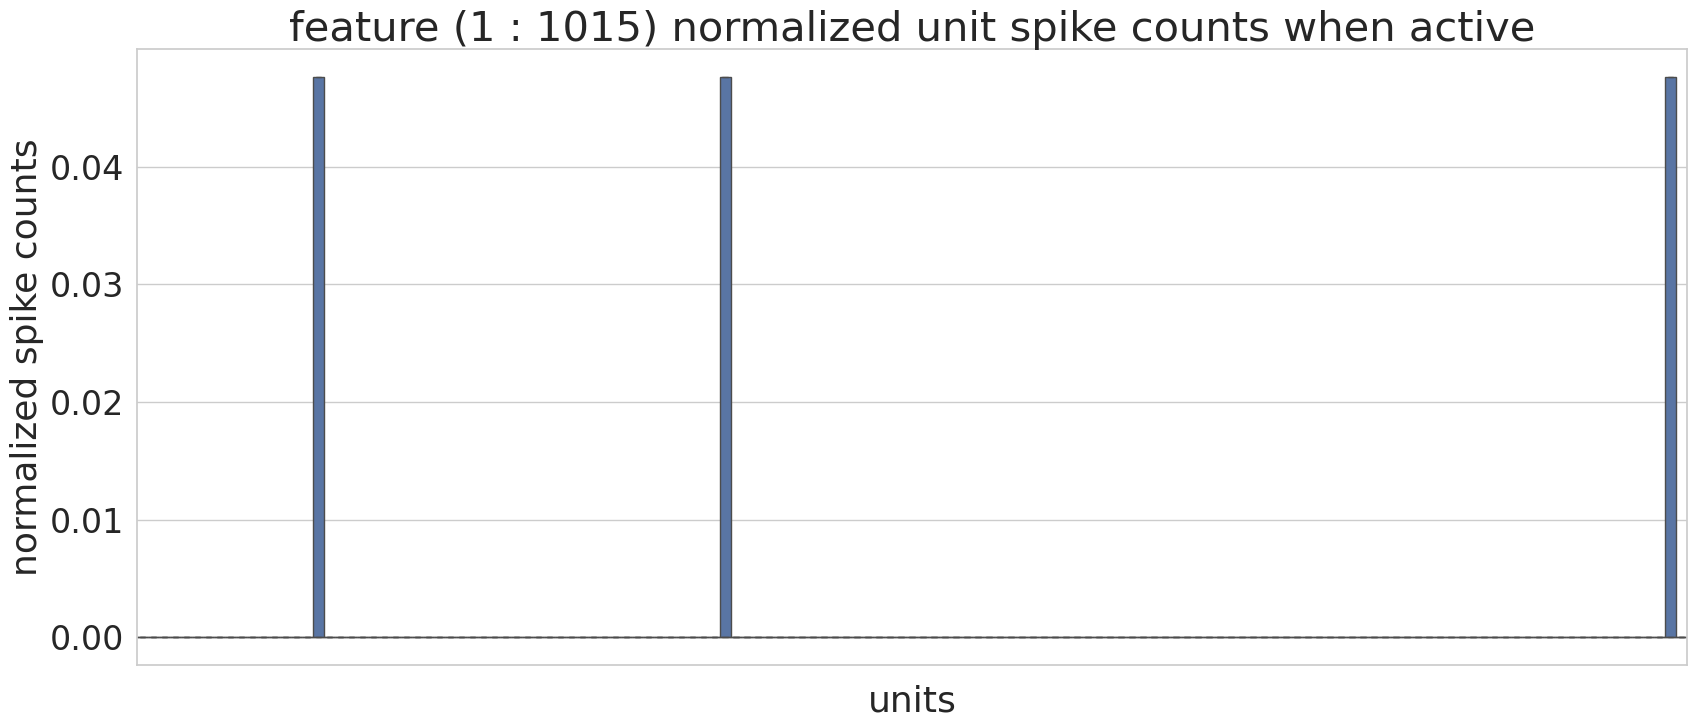

In [78]:
"""Visualize unit spiking variability over SAE feature activity."""

fig, ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(
    x="variable", 
    y="value", 
    data=pd.melt(spk_cts_df.iloc[f_ex_idxs]), 
    showfliers=False,
    width=1,
    whis=0.75, 
    ax=ax
)
ax.set_xlabel("units", fontsize=26)
ax.set_ylabel("normalized spike counts", fontsize=26)# ax.set_yticks([])
ax.set_xticklabels([])
# Set yticklabel font size
ax.tick_params(axis="y", labelsize=24)
ax.set_title(f"feature ({inst_i} : {feat_i}) normalized unit spike counts when active", fontsize=30)

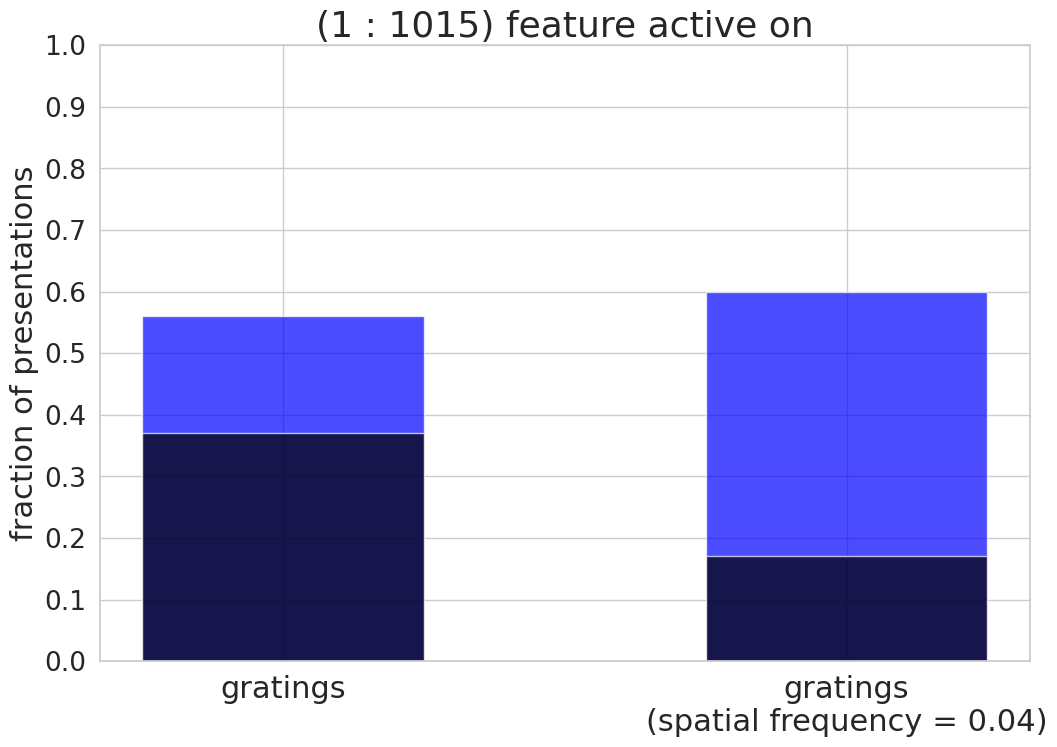

In [77]:
"""Visualize SAE-natural feature confusion matrix."""

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(
    x=[
        "gratings", 
        "gratings", 
        "gratings\n(spatial frequency = 0.04)", 
        "gratings\n(spatial frequency = 0.04)"
    ],
    height=[0.56, 0.37, 0.6, 0.17],
    color=["blue", "black", "blue", "black"],
    alpha=0.7,
    width=0.5
)

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.bar(
#     x=[
#         "flashes", 
#         "flashes", 
#     ],
#     height=[0.89, 0.03],
#     color=["blue", "black"],
#     alpha=0.7,
#     width=0.3
# )

ax.set_title(f"({inst_i} : {feat_i}) feature active on", fontsize=26)

# update fontsizes of ticks labels and titles
ax.tick_params(axis="x", labelsize=22)
ax.tick_params(axis="y", labelsize=19)
ax.set_ylabel("fraction of presentations", fontsize=22)
# ax.set_xticklabels(["drifting_gratings", "", "drifting_gratings\n(temporal frequency < 4 Hz)", ""])
ax.set_yticks(np.arange(0, 1.1, 0.1))

# fig.tight_layout()


## Create visualizations of some interesting SAE stuff

### Visualize some stuff about MSAE levels

In [ ]:
"""Visualize heatmap of feature correlations across MSAE levels."""

acts_df_feat_on_idx = np.logical_and(
    acts_df["feature_idx"].isin(features_df["feature_idx"].unique()), 
    acts_df["instance_idx"] == 0
)

acts_df_comp = acts_df[acts_df_feat_on_idx].copy().drop(
    columns=["activation_value", "instance_idx"], axis=1
)

feature_idxs = np.sort(acts_df_comp["feature_idx"].unique())
corr_mat_idxs = np.arange(0, len(feature_idxs))
corr_mat_feat_idx_map = {feature_idxs[i]: corr_mat_idxs[i] for i in range(len(feature_idxs))}
acts_df_comp["corr_mat_idx"] = acts_df_comp["feature_idx"].map(corr_mat_feat_idx_map)

feat_on_mask = np.zeros((n_recon_examples, len(feature_idxs)))
feat_on_mask[acts_df_comp["example_idx"].values, acts_df_comp["corr_mat_idx"].values] = True

tot_feat_act = feat_on_mask.sum(axis=0)

feat_corr = t.tensor(feat_on_mask.T, device=device) @ t.tensor(feat_on_mask, device=device)
feat_corr_norm = (feat_corr / t.tensor(tot_feat_act, device=device).unsqueeze(0))

l0_co_idx = np.where(feature_idxs > 256)[0][0]
l1_co_idx = np.where(feature_idxs > 512)[0][0]

/tmp/ipykernel_1776695/1967197834.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




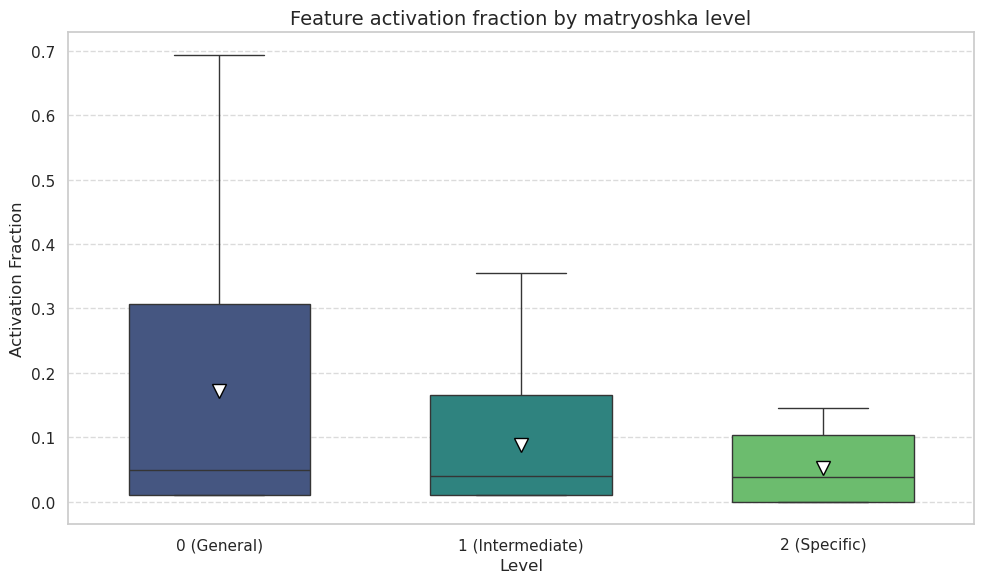

In [433]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

l0_act_frac = features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"] + 0.01

l1_act_frac = features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"] + 0.01

l2_act_frac = features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"] - 0.01
l2_act_frac = l2_act_frac.clip(lower=0)

# First, create a dataframe to hold all three sets of data with appropriate labels
boxplot_data = pd.DataFrame({
    "Layer": ["0 (General)"] * len(l0_act_frac) + 
             ["1 (Intermediate)"] * len(l1_act_frac) + 
             ["2 (Specific)"] * len(l2_act_frac),
    "Activation Fraction": pd.concat([l0_act_frac, l1_act_frac, l2_act_frac])
})

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="Layer", 
    y="Activation Fraction", 
    data=boxplot_data,
    showfliers=False,  # This hides the outliers
    width=0.6,         # Controls the width of the boxes
    palette="viridis",  # Optional: choose a color palette
    # show mean
    showmeans=True,
    meanprops={"marker": "v", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10},
)

# Customize the plot
plt.title("Feature activation fraction by matryoshka level", fontsize=14)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Activation Fraction", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

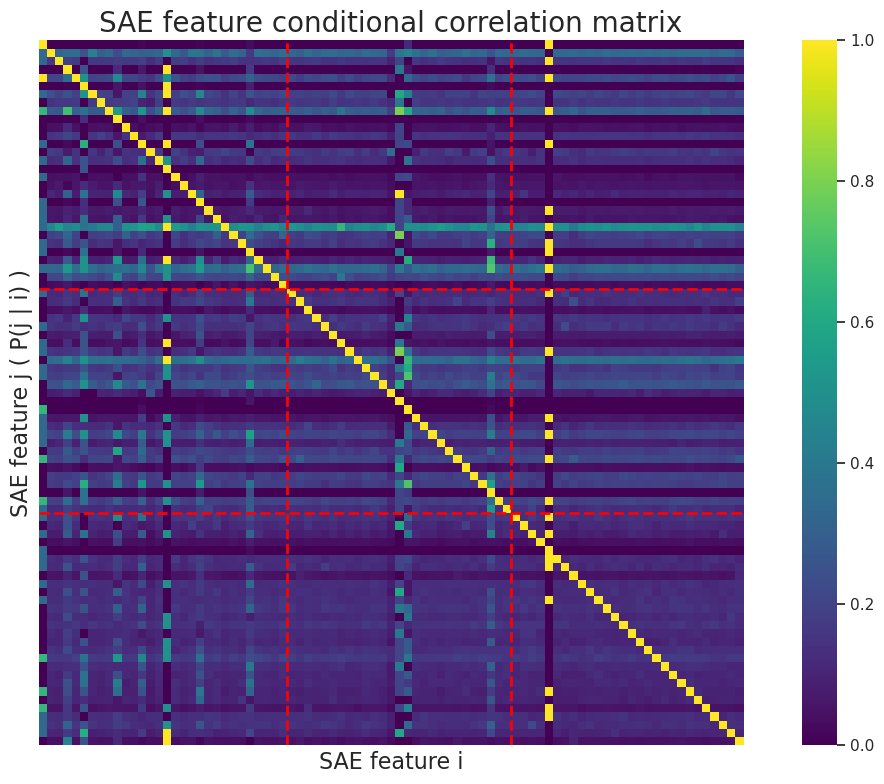

In [ ]:
"""Plot heatmap."""

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    asnumpy(feat_corr_norm), 
    cmap="viridis", 
    vmin=0, 
    vmax=1, 
    square=True,
    xticklabels=range(feat_on_mask.shape[1]),
    yticklabels=range(feat_on_mask.shape[1]),
    ax=ax
)
ax.set_title("SAE feature conditional correlation matrix", fontsize=20)
ax.set_xlabel("SAE feature i", fontsize=16)
ax.set_ylabel("SAE feature j ( P(j | i) )", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Draw red horizontal and vertical lines at l0_co_idx and l1_co_idx
for idx in [l0_co_idx, l1_co_idx]:
    ax.axhline(y=idx, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=idx, color="red", linestyle="--", linewidth=2)

plt.tight_layout()

### Visualize MSAE latents as bases of neural manifolds

In [ ]:

# For SAE features: look at manifolds, feature activity over time (over stimuli xaxis bar), 
# extra: feature correlations ?

inst = 0
features_df.sort_values("activation_std", ascending=True)
acts_df_man = acts_df[acts_df["feature_idx"].isin([246, 41, 22])]
acts_df_man = acts_df_man[acts_df_man["instance_idx"] == inst]

In [ ]:
display(acts_df_man)

,example_idx,instance_idx,feature_idx,activation_value
1,0,0,41,0.063477
23,1,0,41,0.063477
45,2,0,41,0.063477
67,3,0,41,0.063477
89,4,0,41,0.063477
...,...,...,...,...
8748904,182270,0,41,0.057861
8748918,182270,0,246,0.302734
8748965,182271,0,22,0.097168
8748968,182271,0,41,0.057617


In [ ]:
"""Generate a df of activations of latents over time"""

man_vals = np.zeros((n_recon_examples, 3))

for i, feat_i in enumerate([246, 41, 22]):
    idxs = acts_df_man[acts_df_man["feature_idx"] == feat_i]["example_idx"].values
    man_vals[idxs, i] = acts_df_man[acts_df_man["feature_idx"] == feat_i]["activation_value"].values

man_df = pd.DataFrame(man_vals)
man_df.index = man_df.index * bin_s


array([[0.        , 0.06347656, 0.        ],
       [0.        , 0.06347656, 0.        ],
       [0.        , 0.06347656, 0.        ],
       ...,
       [0.41210938, 0.0859375 , 0.05175781],
       [0.30273438, 0.05786133, 0.06933594],
       [0.40234375, 0.05761719, 0.09716797]])

In [ ]:
display(man_df)

,0,1,2
0.00,0.000000,0.063477,0.000000
0.05,0.000000,0.063477,0.000000
0.10,0.000000,0.063477,0.000000
0.15,0.000000,0.063477,0.000000
0.20,0.000000,0.063477,0.000000
...,...,...,...
9113.35,0.312500,0.158203,0.000000
9113.40,0.500000,0.097168,0.086426
9113.45,0.412109,0.085938,0.051758
9113.50,0.302734,0.057861,0.069336


In [ ]:
"""Visualize the 3D manifold of latents."""

def create_enhanced_3d_animation(df, save_path=None, fps=30, dpi=100):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract data
    x_data = df.iloc[:, 0].values
    y_data = df.iloc[:, 1].values
    z_data = df.iloc[:, 2].values
    
    # Calculate ranges for better visualization
    x_range = max(x_data) - min(x_data)
    y_range = max(y_data) - min(y_data)
    z_range = max(z_data) - min(z_data)
    
    # Set equal aspect ratio
    max_range = max(x_range, y_range, z_range) / 2
    mid_x = (max(x_data) + min(x_data)) / 2
    mid_y = (max(y_data) + min(y_data)) / 2
    mid_z = (max(z_data) + min(z_data)) / 2
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set labels and title
    ax.set_xlabel(df.columns[0], fontsize=12)
    ax.set_ylabel(df.columns[1], fontsize=12)
    ax.set_zlabel(df.columns[2], fontsize=12)
    ax.set_title('Top 3 SAE latents manifold over time', fontsize=14)
    
    # Add grid
    ax.grid(True)
    
    # Initialize line and point objects
    line, = ax.plot([], [], [], lw=2, color='blue')
    point, = ax.plot([], [], [], 'ro', markersize=10)
    
    # Add a shadow on the floor
    ax.plot(x_data, y_data, min(z_data), 'k--', alpha=0.2)
    
    # Add vector from origin to current point
    vector, = ax.plot([0, 0], [0, 0], [0, 0], 'g-', lw=1.5, alpha=0.7)
    
    # Time display
    time_template = 'Time = %.3f s'
    time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12)
    
    # Progress bar
    progress_bar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
    progress_bar = plt.Rectangle((0, 0), 0, 1, fc='blue', alpha=0.5)
    progress_bar_ax.add_patch(progress_bar)
    progress_bar_ax.set_xlim(0, 1)
    progress_bar_ax.set_ylim(0, 1)
    progress_bar_ax.axis('off')
    
    # Get time values
    if isinstance(df.index[0], (int, float)):
        times = df.index.values
    else:
        times = np.arange(len(df))
    
    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
        vector.set_data([], [])
        vector.set_3d_properties([])
        time_text.set_text('')
        progress_bar.set_width(0)
        return line, point, vector, time_text, progress_bar
    
    def update(frame):
        i = min(frame, len(df) - 1)
        progress = i / (len(df) - 1)
        
        # Update line data
        line.set_data(x_data[:i+1], y_data[:i+1])
        line.set_3d_properties(z_data[:i+1])
        
        # Update current point
        point.set_data([x_data[i]], [y_data[i]])
        point.set_3d_properties([z_data[i]])
        
        # Update vector from origin
        vector.set_data([0, x_data[i]], [0, y_data[i]])
        vector.set_3d_properties([0, z_data[i]])
        
        # Update time text
        current_time = times[i] if i < len(times) else times[-1]
        time_text.set_text(time_template % current_time)
        
        # Update progress bar
        progress_bar.set_width(progress)
        
        # Rotate view slightly for 3D effect
        ax.view_init(elev=30, azim=i / 5 % 360)
        
        return line, point, vector, time_text, progress_bar
    
    # Sample a reasonable number of frames
    num_frames = min(len(df), 300)
    frame_indices = np.linspace(0, len(df)-1, num_frames, dtype=int)
    
    ani = FuncAnimation(fig, update, frames=frame_indices,
                        init_func=init, blit=False, interval=1000/fps)
    
    if save_path:
        ani.save(save_path, writer='pillow', fps=fps, dpi=dpi)
        print(f"Enhanced animation saved to {save_path}")
    
    plt.close()
    return ani

save_path = out_dir / f"{session_id}" / "sae_features" / "sae_0" / "enhanced_3d_animation.gif"
enhanced_ani = create_enhanced_3d_animation(man_df.iloc[::500], save_path=save_path, fps=15, dpi=200)
# HTML(enhanced_ani.to_jshtml())  # view it directly in the notebook (may cause issues)

Enhanced animation saved to /nfs/nhome/live/jbhagat/mini/data/allen_data/sessions_proc/742951821/sae_features/sae_0/enhanced_3d_animation.gif


## SAE comparisons to other methods (e.g. PCA, NMF)

### PCA comparison

#### Structure of latents

In [43]:
"""Get SAE feature weights for features in `features_df`"""

inst = 1
features_df = features_df[features_df["instance_idx"] == inst]
features_df = features_df.nlargest(200, "activation_frac")
feature_idxs = features_df["feature_idx"].values

w_enc = sae.W_enc[inst, feature_idxs].float()

w_enc = w_enc / w_enc.norm(dim=1, keepdim=True)

In [44]:
"""Run PCA on spike counts."""

# Compute eigendecomposition of covariance matrix
cov_mat = t.cov(spk_cts.T)
eig_vals, eig_vecs = t.linalg.eigh(cov_mat.float())

eig_vecs = eig_vecs.T / eig_vecs.T.norm(dim=1, keepdim=True)

Text(0.5, 1.0, 'Cosine similarities of l2-normed weights')

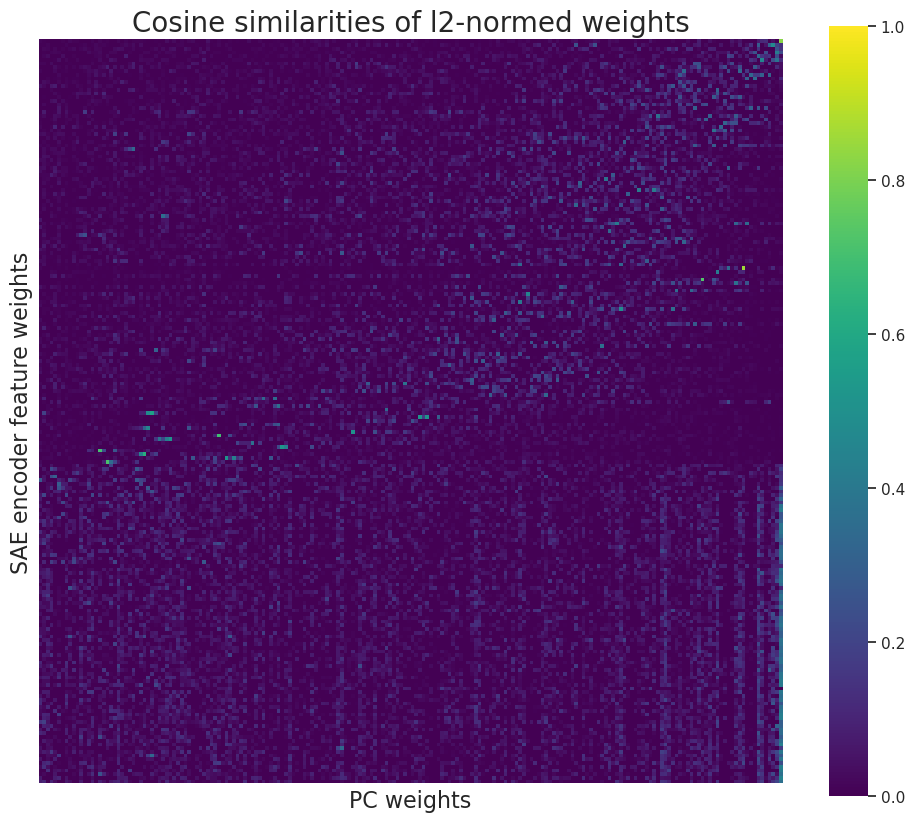

In [ ]:
"""Plot heatmap of cossim between SAE feature weights and PC feature weights."""

cos_sim = einsum(w_enc, eig_vecs, "sae_feat unit, pc_feat unit -> sae_feat pc_feat")

fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(
    asnumpy(cos_sim),
    cmap="viridis", 
    vmin=0, 
    vmax=1, 
    square=True,
    xticklabels=[],
    yticklabels=[],
    ax=ax
)
ax.set_xlabel("PC weights", fontsize=16)
ax.set_ylabel("SAE encoder feature weights", fontsize=16)
ax.set_title("Cosine similarities of l2-normed weights", fontsize=20)

#### Latent trajectories over time

In [88]:
"""Compute latent trajectories."""

# PC trajectories over time (PC scores)
pc_scores = einsum(
    spk_cts[:n_recon_examples].float(), 
    eig_vecs, 
    "example unit, feat unit -> example feat"
)
pc_scores = pc_scores / pc_scores.norm(dim=1, keepdim=True)
pc_scores[t.isnan(pc_scores)] = 0  # fill 0 / 0 nans with 0

# SAE feature activations over time
sae_feat_acts = t.zeros((n_recon_examples, w_enc.shape[0]), device=device)
acts_df_filt = acts_df[np.logical_and(
    acts_df["instance_idx"] == inst, acts_df["feature_idx"].isin(feature_idxs)
)]
idx_map = {idx: pos for pos, idx in enumerate(feature_idxs)}
mapped_idxs = t.tensor([idx_map[idx] for idx in acts_df_filt["feature_idx"].values])
sae_feat_acts[acts_df_filt["example_idx"].values, mapped_idxs] = (
    t.tensor(acts_df_filt["activation_value"].values, device=device)
)
sae_feat_acts = sae_feat_acts / sae_feat_acts.norm(dim=1, keepdim=True)

Text(0.5, 1.0, 'Cosine similarities of l2-normed latent trajectories')

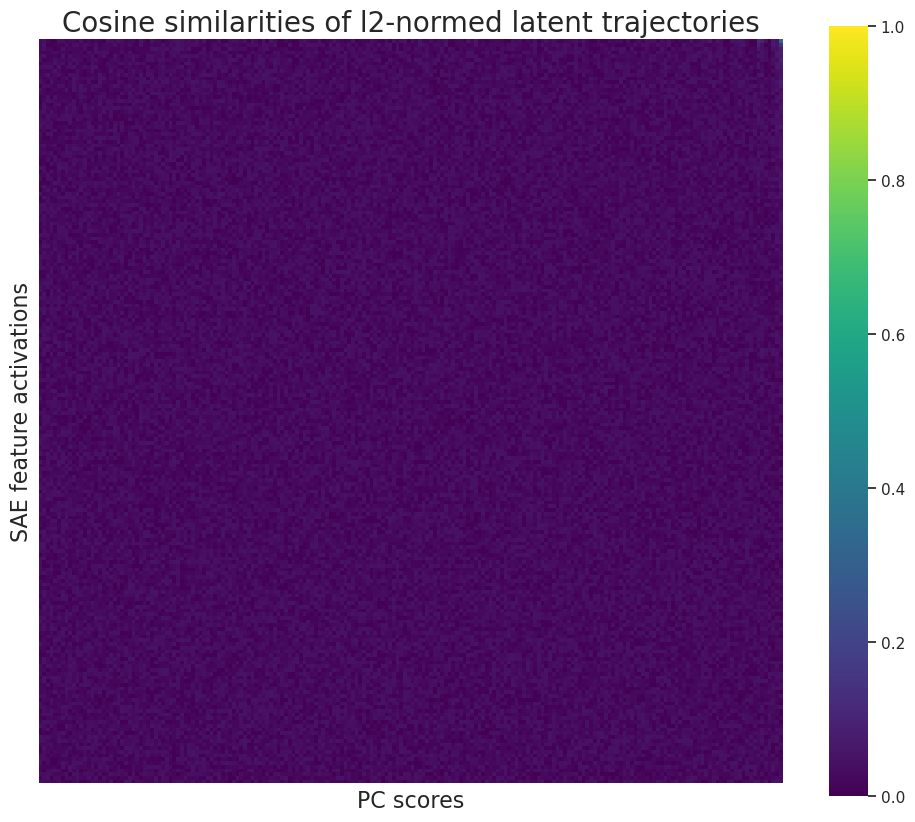

In [ ]:
"""Compute cosine similarity between latent trajectories and plot heatmap."""

# Compute cossim, then ensure that zero-zero matches are set to 0 (instead of 1)
# Iterate through each pair of features to properly handle zero-zero matches
cos_sim = t.zeros((w_enc.shape[0], eig_vecs.shape[0]), device=device)

for i in range(w_enc.shape[0]):  # For each SAE feature
    for j in range(eig_vecs.shape[0]):  # For each PC feature
        # Get trajectories for this feature pair
        sae_traj = sae_feat_acts[:, i]
        pc_traj = pc_scores[:, j]
        
        # Check if either feature is ever active
        if (sae_traj == 0).all() or (pc_traj == 0).all():
            cos_sim[i, j] = 0
        else:
            # Apply weights that are zero wherever both features are zero
            weights = ((sae_traj != 0) | (pc_traj != 0)).float()
            # Weighted dot product
            cos_sim[i, j] = (sae_traj * pc_traj * weights).sum() / weights.sum()


fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(
    asnumpy(cos_sim), 
    cmap="viridis", 
    vmin=0, 
    vmax=1, 
    square=True,
    xticklabels=[],
    yticklabels=[],
    ax=ax
)
ax.set_xlabel("PC scores", fontsize=16)
ax.set_ylabel("SAE feature activations", fontsize=16)
ax.set_title("Cosine similarities of l2-normed latent trajectories", fontsize=20)

### NMF comparison

In [ ]:
# Do the same comparison for the max-normalized NMF weights after running NMF on the spike counts

## Features found

### Possible

- flashes
- gabors

---

- flashes
- natural scenes / movies
- orientations or motion or running speed ?

---

High-level:

- fire for running speed?
- only fire for spontaneous?
- only fire for flashes?
- only fire for gabors in particular locations? -> single cell?
- only fire for motion? (drifting gratings, movies) -> single cell?
- only fire for certain orientations? -> single cell?
- only fire for natural scenes or movies?

### Actual

#### Session 732592105

##### sae_0

#### Session 742851821

##### sae_0

## Scratchpad below here

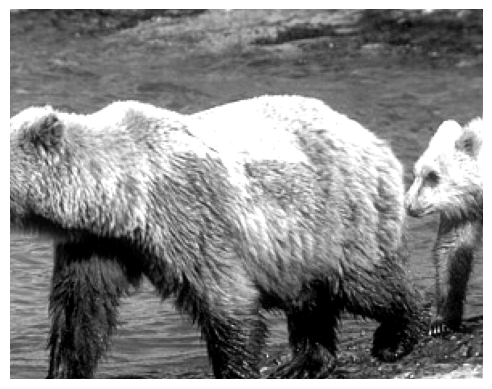

In [140]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cache.get_natural_scene_template(0), cmap="gray")

In [126]:
metadata[metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

array([4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918,
       4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929,
       4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940,
       4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951,
       4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962,
       4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973,
       4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984,
       4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995,
       4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006,
       5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017,
       5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026])

In [ ]:
# session_data.presentationwise_spike_times()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
21.579087,0,915959976,0.000013
21.579387,0,915965400,0.000313
21.579587,0,915959890,0.000513
21.579787,0,915960262,0.000713
21.579961,0,915958751,0.000887
...,...,...,...
9143.415088,70387,915959974,0.249451
9143.415170,70387,915964551,0.249533
9143.415255,70387,915959708,0.249618


In [ ]:
# session_data.conditionwise_spike_statistics()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
915956282,0,6759,15,450.600000,617.813518,159.518764
915956304,0,10492,15,699.466667,1009.571187,260.670160
915956340,0,11240,15,749.333333,950.352316,245.379913
915956345,0,13776,15,918.400000,1291.497072,333.463110
915956349,0,22881,15,1525.400000,2196.381954,567.103382
...,...,...,...,...,...,...
915966905,5026,4,50,0.080000,0.444467,0.062857
915966931,5026,14,50,0.280000,0.858095,0.121353
915966963,5026,0,50,0.000000,0.000000,0.000000
